# Домашняя работа. Деревья решений.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](99-extra__ml-course-msu-Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиций деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'./data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = './data/winequality-red.csv'
data = pd.read_csv(file_path, sep=';')
data.columns = data.columns.str.strip()
print(data.head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Unnamed: 12  
0      9.4        5          NaN  
1      9.8      

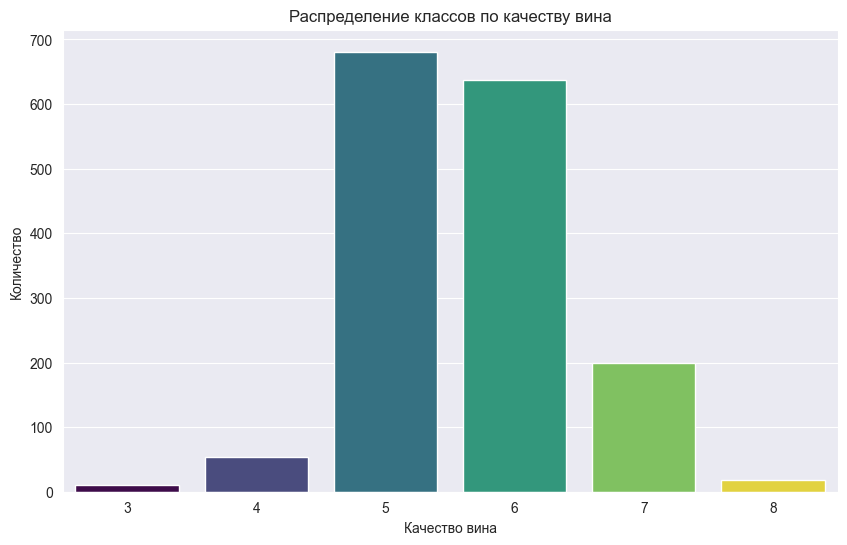

In [2]:
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=data, hue='quality', palette='viridis', legend=False)
plt.title('Распределение классов по качеству вина')
plt.xlabel('Качество вина')
plt.ylabel('Количество')
plt.show()


In [3]:
class_counts = data['quality'].value_counts().sort_index()
print("Количество представителей каждого класса:")
print(class_counts)


Количество представителей каждого класса:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


In [4]:
X = data.drop(columns=['quality'])
y = data['quality']

print(f"Форма признаков (X): {X.shape}")
print(f"Форма целевого признака (y): {y.shape}")


Форма признаков (X): (1599, 12)
Форма целевого признака (y): (1599,)


### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [5]:
import pandas as pd

file_path = './data/winequality-red.csv'
data = pd.read_csv(file_path, sep=';')
data.columns = data.columns.str.strip()

X = data.drop(columns=['quality'])
y = data['quality']

print("Первые строки данных:")
print(data.head())


Первые строки данных:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Unnamed: 12  
0      9.4        5          

In [6]:
constant_columns = [col for col in X.columns if X[col].nunique() == 1]
print("Столбцы с постоянными значениями:", constant_columns)

data = data.drop(columns=['Unnamed: 12'])

X = data.drop(columns=['quality'])


Столбцы с постоянными значениями: []


In [7]:
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

if np.isnan(X).any():
    print("В данных после обработки есть NaN.")
if np.isinf(X).any():
    print("В данных после обработки есть бесконечные значения.")


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

cv = KFold(n_splits=5, shuffle=True, random_state=42)

classifiers = {
    "KNeighborsClassifier (без масштабирования)": KNeighborsClassifier(n_neighbors=10),
    "KNeighborsClassifier (с масштабированием)": KNeighborsClassifier(n_neighbors=10),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "BaggingClassifier (100 деревьев)": BaggingClassifier(n_estimators=100, random_state=42),
    "BaggingClassifier (100 деревьев, 50% признаков)": BaggingClassifier(
        n_estimators=100, max_features=0.5, random_state=42),
    "RandomForestClassifier (100 деревьев)": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, clf in classifiers.items():
    data = X_scaled if "масштабированием" in name else X
    
    scores = cross_val_score(clf, data, y, cv=cv, scoring='accuracy')
    
    results[name] = np.mean(scores)


In [10]:
print("\nСредние значения метрики точности для каждой модели:")
for name, score in results.items():
    print(f"{name}: {score:.4f}")



Средние значения метрики точности для каждой модели:
KNeighborsClassifier (без масштабирования): 0.5122
KNeighborsClassifier (с масштабированием): 0.5798
RidgeClassifier: 0.5835
DecisionTreeClassifier: 0.6179
BaggingClassifier (100 деревьев): 0.6992
BaggingClassifier (100 деревьев, 50% признаков): 0.6955
RandomForestClassifier (100 деревьев): 0.6998


### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без
- почему масштабирование не важно для деревьев решений
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

#### Ответы:

1. **KNeighborsClassifier** зависит от вычисления расстояний между объектами, а масштабирование признаков (например, с помощью StandardScaler) приводит все признаки к одному масштабу. Без масштабирования признаки с большими диапазонами значений могут доминировать в расчете расстояний, искажая результаты. Масштабирование улучшает качество, так как все признаки оказывают равный вклад в определение ближайших соседей.

2. **Деревья решений** не зависят от расстояний между объектами, так как они принимают решения на основе пороговых значений признаков. Масштабирование не влияет на то, как дерево строит разделяющие гиперплоскости, поскольку разбиение происходит по конкретным значениям признаков, а не по их относительным величинам. Таким образом, дерево решений не чувствительно к масштабу данных.

3. Использование случайного подмножества признаков для каждого дерева (например, в **Random Forest**) снижает **корреляцию** между деревьями, что улучшает **общую стабильность** и точность ансамбля. Это позволяет избежать переобучения, так как каждое дерево обучается на меньшем количестве признаков и не может «запомнить» все данные, что повышает обобщающую способность ансамбля.

4. Модель с наибольшим отклонением от среднего качества предсказаний обычно — это **KNeighborsClassifier** (особенно без масштабирования), потому что она чувствительна к локальным колебаниям в данных. KNN может сильно варьироваться в зависимости от распределения данных, выбросов и расположения соседей. Переобучение или недостаточная обобщающая способность могут привести к сильному отклонению точности на разных фолдах в кросс-валидации.

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

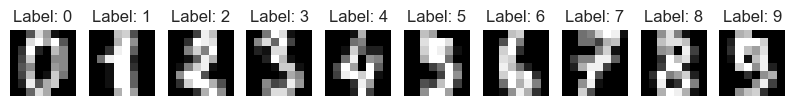

In [11]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

X = digits.data
y = digits.target

fig, axes = plt.subplots(1, 10, figsize=(10, 2))

for i in range(10):
    axes[i].imshow(X[i].reshape(8, 8), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {y[i]}")

plt.show()


### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [12]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()
X = digits.data
y = digits.target

cv = KFold(n_splits=10, shuffle=True, random_state=42)

classifiers = {
    "DecisionTreeClassifier (по умолчанию)": DecisionTreeClassifier(random_state=42),
    "BaggingClassifier (100 деревьев)": BaggingClassifier(n_estimators=100, random_state=42),
    "BaggingClassifier (100 деревьев, max_features = sqrt(n_features))": BaggingClassifier(
        n_estimators=100, max_features=int(np.sqrt(X.shape[1])), random_state=42),
    "BaggingClassifier (100 деревьев, max_features = n_features // 2)": BaggingClassifier(
        n_estimators=100, max_features=X.shape[1] // 2, random_state=42),
    "RandomForestClassifier (100 деревьев)": RandomForestClassifier(n_estimators=100, random_state=42)
}

def evaluate_classifiers(X, y, classifiers, cv):
    results = {}
    
    for name, clf in classifiers.items():
        scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        results[name] = np.mean(scores)
    
    return results

results = evaluate_classifiers(X, y, classifiers, cv)

print("\nСредние значения метрики точности для каждой модели:")
for name, score in results.items():
    print(f"{name}: {score:.4f}")



Средние значения метрики точности для каждой модели:
DecisionTreeClassifier (по умолчанию): 0.8548
BaggingClassifier (100 деревьев): 0.9494
BaggingClassifier (100 деревьев, max_features = sqrt(n_features)): 0.9521
BaggingClassifier (100 деревьев, max_features = n_features // 2): 0.9739
RandomForestClassifier (100 деревьев): 0.9783


### 2.3 В чём разница? (3 балла)

Ответье на вопрос: 

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?




- **Ограничение на количество признаков для разбиений дерева** (в DecisionTreeClassifier) ограничивает выбор признаков только на уровне разбиений, но дерево строится на всём наборе признаков, что может привести к переобучению. Это ограничение снижает гибкость дерева в поиске наилучших разбиений, что ухудшает качество.
  
- **Ограничение на количество признаков для построения дерева** в BaggingClassifier ограничивает выбор признаков при построении каждого дерева. Это снижает корреляцию между деревьями в ансамбле, что улучшает обобщающую способность и снижает переобучение.

#### В чём магия?
Магия заключается в том, что ограничение на количество признаков при обучении каждого дерева в BaggingClassifier уменьшает зависимость деревьев друг от друга, повышая устойчивость модели. Это снижает переобучение и улучшает качество предсказания, поскольку каждый классификатор работает с разными признаками.

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

cv = KFold(n_splits=10, shuffle=True, random_state=42)

n_estimators_list = [1, 5, 10, 15, 50, 100, 150, 200, 300]

scores = []

for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    score = cross_val_score(rf, X, y, cv=cv, scoring='accuracy').mean()
    scores.append(score)


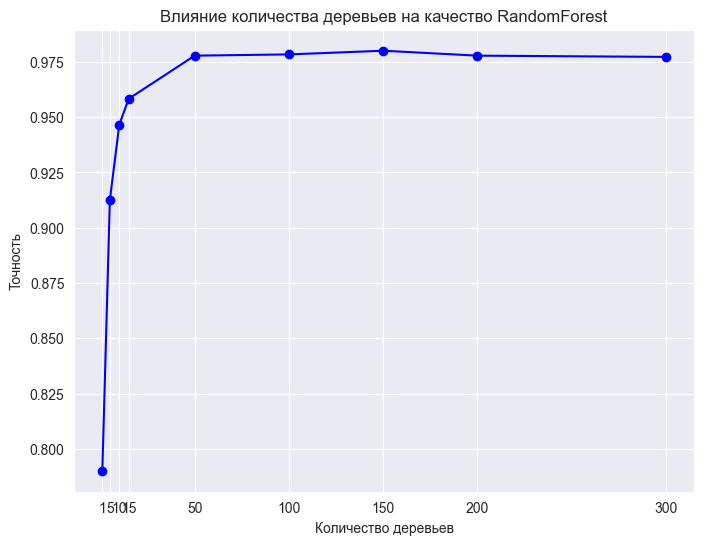

Наилучшее качество достигается при 150 деревьях: 0.9800


In [14]:
plt.figure(figsize=(8, 6))
plt.plot(n_estimators_list, scores, marker='o', linestyle='-', color='b')
plt.title('Влияние количества деревьев на качество RandomForest')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.grid(True)
plt.xticks(n_estimators_list)
plt.show()

best_n_estimators = n_estimators_list[np.argmax(scores)]
best_score = max(scores)

print(f"Наилучшее качество достигается при {best_n_estimators} деревьях: {best_score:.4f}")


### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

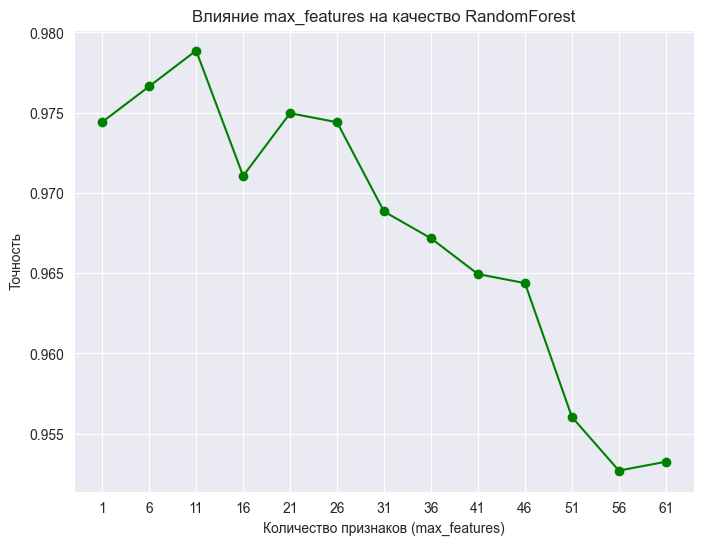

Наилучшее качество достигается при 11 признаках: 0.9789


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

cv = KFold(n_splits=10, shuffle=True, random_state=42)

max_features_list = list(range(1, 65, 5))

scores = []

for max_features in max_features_list:
    rf = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42)
    score = cross_val_score(rf, X, y, cv=cv, scoring='accuracy').mean()
    scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(max_features_list, scores, marker='o', linestyle='-', color='g')
plt.title('Влияние max_features на качество RandomForest')
plt.xlabel('Количество признаков (max_features)')
plt.ylabel('Точность')
plt.grid(True)
plt.xticks(max_features_list)
plt.show()

best_max_features = max_features_list[np.argmax(scores)]
best_score = max(scores)

print(f"Наилучшее качество достигается при {best_max_features} признаках: {best_score:.4f}")


### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?


1. **Что происходит с ростом числа деревьев у случайного леса? Можно ли просто всегда брать 5000 деревьев и быть счастливым?**  
   - С ростом числа деревьев качество предсказаний стабилизируется, а ошибка на тестовых данных уменьшается (снижается дисперсия модели). Однако, после определённого количества деревьев (например, 100-200) улучшения становятся незначительными, а вычислительные затраты продолжают расти. Поэтому брать 5000 деревьев нецелесообразно в большинстве задач.

2. **Как зависит качество предсказания в дереве в зависимости от max_features?**  
   - Качество предсказания сначала увеличивается с ростом `max_features`, так как деревья получают больше информации для разбиений, но после определённого значения может начать снижаться из-за уменьшения разнообразия деревьев, что увеличивает переобучение.

3. **Почему качество зависит от max_features?**  
   - max_features контролирует количество признаков, доступных для разбиения в каждом узле дерева. Малое значение способствует разнообразию деревьев (увеличивает устойчивость к переобучению), а большое значение позволяет каждому дереву лучше подстраиваться под данные (но риск переобучения возрастает).

4. **Как глубина деревьев влияет на качество случайного леса?**  
   - Небольшая глубина может привести к недообучению (модель недостаточно сложна для захвата закономерностей в данных). Слишком большая глубина ведёт к переобучению деревьев, но случайный лес за счёт ансамблирования частично нивелирует этот эффект. Оптимальная глубина зависит от данных.

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)